In [60]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from autoplan.generator import ProgramGenerator
from grammars.pythagorean.program import Program, PythagoreanLabels
from grammars.simple.program import Program as SimpleProgram, SimpleLabels
from autoplan.dataset import build_synthetic_dataset
from autoplan.trainer import ParserTrainer
from autoplan.parsing import ProgramParser
from autoplan.token import JavaTokenizer
from autoplan.vis import plot_all_accuracy, plot_all_cm
from tqdm import tqdm_notebook as tqdm
import torch
import pandas as pd
from pprint import pprint

#device = torch.device('cpu')
device = torch.device('cuda:0')

In [64]:
dataset = build_synthetic_dataset(
    #SimpleLabels, 
    PythagoreanLabels,
    N=1000, 
    tokenizer=JavaTokenizer(),
    #generator=ProgramGenerator(grammar=SimpleProgram()))
    generator=ProgramGenerator(grammar=Program()))

Generating programs...


 16%|█▌        | 162/1000 [00:00<00:00, 1092.97it/s]

Generated 372 unique programs.
Tokenizing programs...


100%|██████████| 1000/1000 [00:00<00:00, 6613.19it/s]

Building dataset metadata...


In [65]:
trainer = ParserTrainer(dataset, device)
losses = []
train_evals = []
val_evals = []

In [75]:
for _ in tqdm(range(20)):
    losses.append(trainer.train_one_epoch())
    train_eval, val_eval = trainer.eval()
    train_evals.append(train_eval)
    val_evals.append(val_eval)

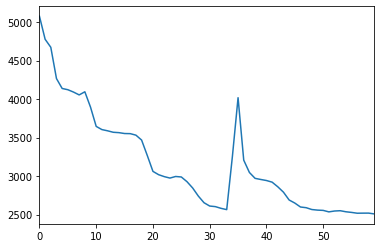

In [76]:
pd.Series(losses).plot()

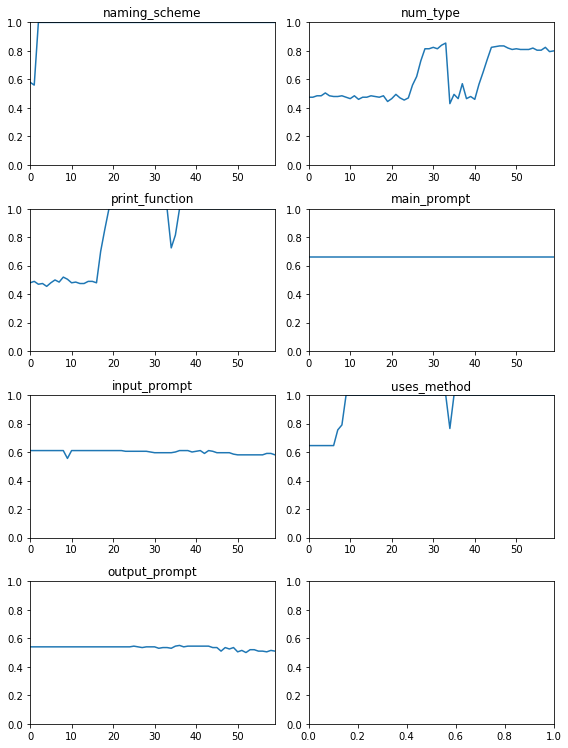

In [77]:
plot_all_accuracy(train_evals)

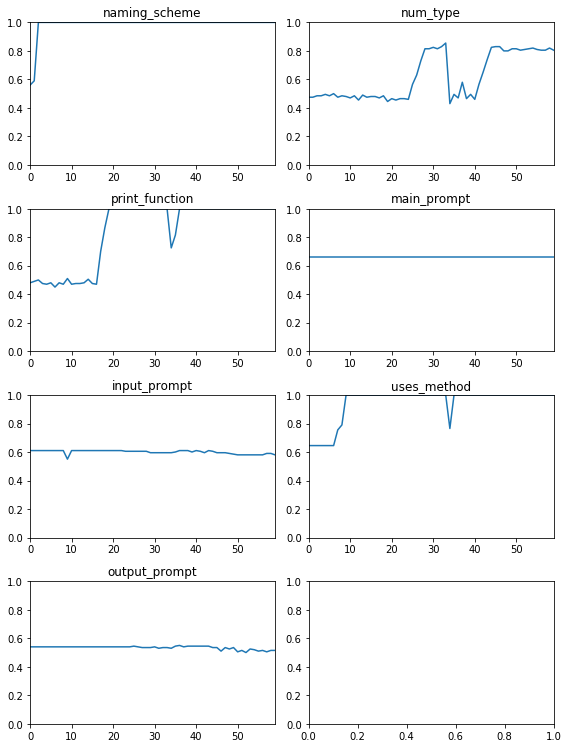

In [78]:
plot_all_accuracy(val_evals)

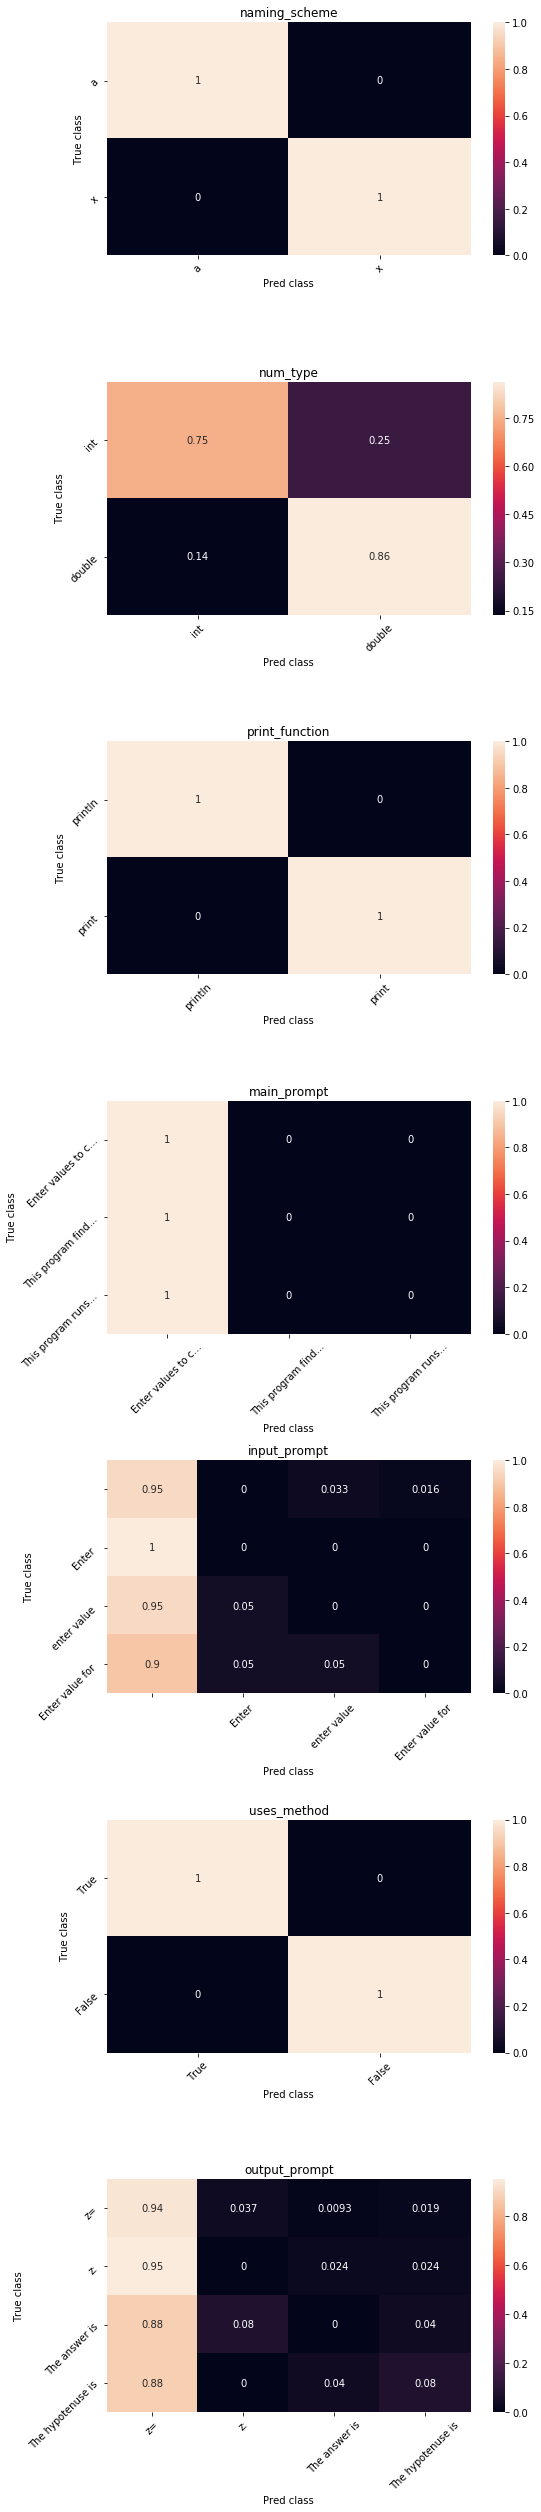

In [81]:
plot_all_cm(val_evals[-1])

In [ ]:
batch = next(iter(dataset.loader(dataset.train_dataset)))
trainer.model.predict(batch['program'], batch['program_len'], batch['trace'], batch['trace_len'], batch['choices'])

In [ ]:
trainer.eval()

In [ ]:
from torch.nn import functional as F
from torch import nn

loss = nn.CrossEntropyLoss()
batch = next(iter(dataset.loader(dataset.train_dataset)))
dataset.readable_choices({'trace': batch['trace'][0], 'choices': batch['choices'][0]})
preds = trainer.model.forward(
    batch['program'], batch['program_len'], batch['trace'], batch['trace_len'], batch['choices'])
F.softmax(preds[0][1]), batch['choices'][0][2]
loss(preds[0][1].unsqueeze(0).cpu(), batch['choices'][0][2].unsqueeze(0).cpu())